In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'f42b9cd594a946eab5fa537aa0db0af9')

In [4]:
def search_images_bing(key, term, max_images: int = 150, **kwargs):    
    params = {'q':term, 'count':max_images}
    headers = {"Ocp-Apim-Subscription-Key":key}
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json() 
   
    # returns an L object to be identical to the original function.
    return L(search_results['value'])

In [5]:
results = search_images_bing(key, 'lightsaber')
imgs = results.attrgot('contentUrl')
imgs[69]

'https://i.pinimg.com/originals/8a/20/3c/8a203c3e5e91edfd6dab8d9007e12ba7.jpg'

In [6]:
dest = 'images/lightsaber.jpg'
download_url(imgs[69], dest)

Path('images/lightsaber.jpg')

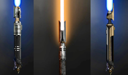

In [7]:
img = Image.open(dest)
img.to_thumb(128,128)

In [8]:
lightsaber_types = ['blue', 'red']
path = Path('lightsabers')

In [9]:
if not path.exists():
    path.mkdir()
    for type in lightsaber_types:
        if (type == 'red'):
            dest = path/'sith'
        else:
            dest = path/'jedi'
        dest.mkdir(exist_ok=True)
        res = search_images_bing(key, f'{type} lightsaber')
        download_images(dest, urls=res.attrgot('contentUrl'))

In [10]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)

(#12) [None,None,None,None,None,None,None,None,None,None...]

In [11]:
lightsabers = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)    
)

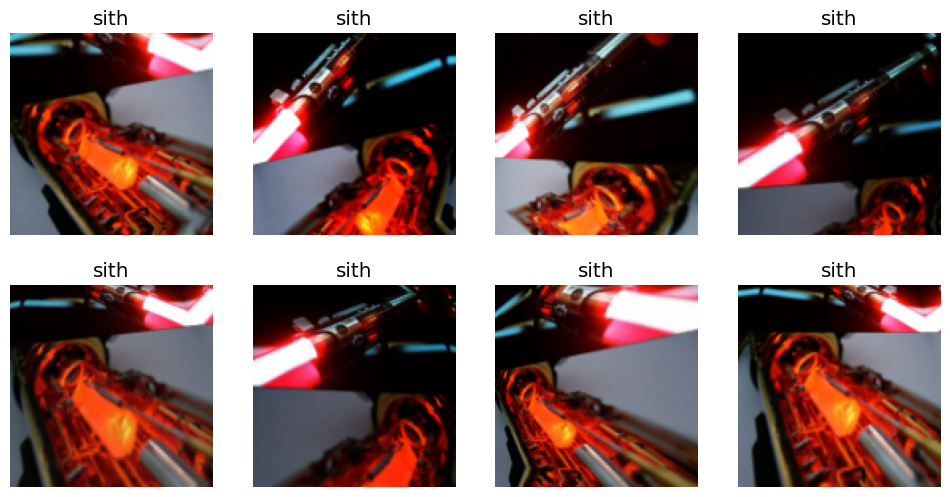

In [12]:
lightsabers = lightsabers.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = lightsabers.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [13]:
lightsabers = lightsabers.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),batch_tfms=aug_transforms())
dls = lightsabers.dataloaders(path)

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.145700,0.685435,0.290909,00:27


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.819697,0.609151,0.290909,00:35
1,0.682664,0.386680,0.127273,00:36
2,0.597030,0.413406,0.163636,00:36
3,0.515278,0.406814,0.145455,00:36


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes sh

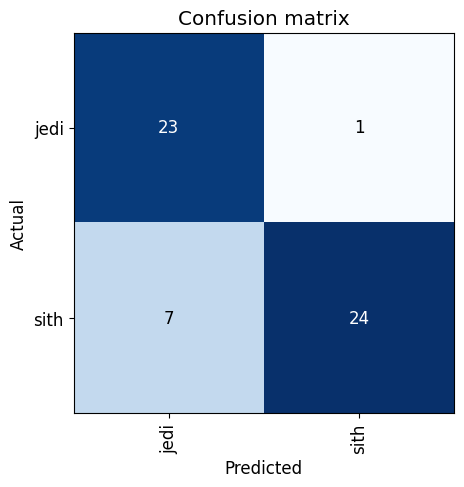

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

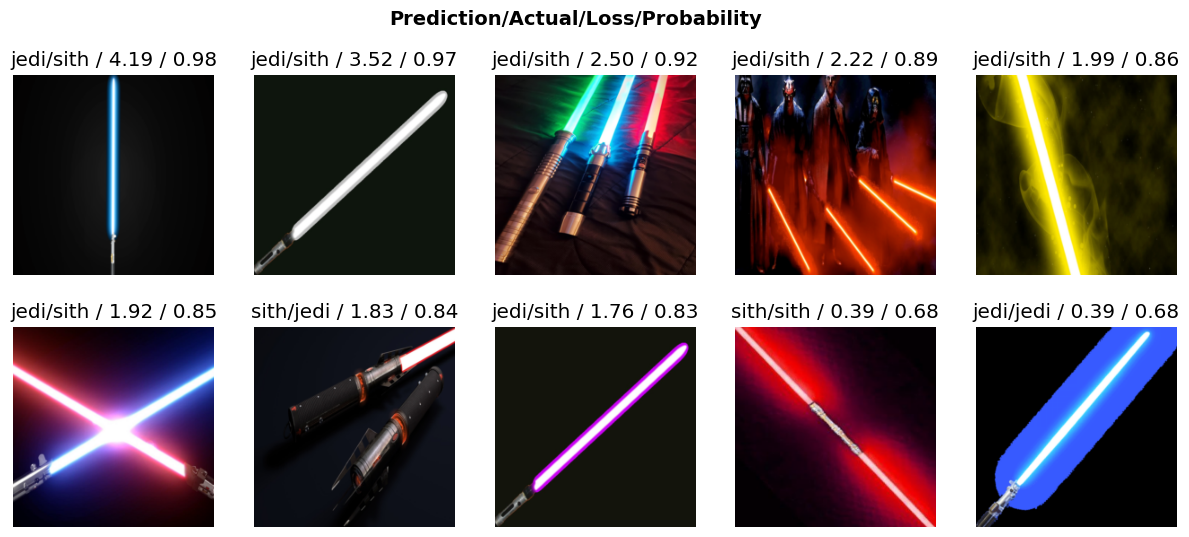

In [16]:
interp.plot_top_losses(10, nrows=2)

In [17]:
learn.export()

In [18]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [19]:
learn = load_learner('export.pkl')

In [20]:
labels = learn.dls.vocab
import skimage

def predict(img):
    img = PILImage.create(img)
    pred, pred_id, prob = learn.predict(img)
    return {labels[i]: float(prob[i]) for i in range(len(labels))}

In [21]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 6.5 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4712 sha256=9fc796ef57886fbec11e0a88bdd637700ea0711f4b554a95dca9fb82bafe24fa
  Stored in directory: /root/.cache/pip/wheels/0c/c2/0e/3b9c6845c6a4e35beb90910cc70d9ac9ab5d47402bd62af0df
Successfully built ffmpy
  Attempting uninstall: mdit-py-plugins
    Found existing installation: mdit-py-plugins 0.3.5
    Uninstalling mdit-py-plugins-0.3.5:
      Successfully uninstalled mdit-py-plugins-0.3.5


In [22]:
import gradio as gr

gr.Interface(fn=predict, 
             title="Lightsaber Classifier",
             description="Is it of a jedi, or a sith, this model shall know",
             inputs=gr.inputs.Image(shape=(512, 512)), 
             outputs=gr.outputs.Label(num_top_classes=3)).launch(share=True)

/opt/conda/lib/python3.10/site-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/opt/conda/lib/python3.10/site-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://6e8c24341d13528cc9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
